In [1]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import rasterio as rio
from rasterio.enums import Resampling
import json
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from PIL import ImageColor
import skimage as ski
import scipy

In [2]:
# Location of data
lc_dir = 'data/lc.json'
sample_dir = "data/Sample_LC_v1.geojson"
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [3]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df['values_normalize'] = lc_df.index + 1
lc_df['palette'] = '#' + lc_df['palette']

# Mapping from old to new values
values = lc_df['values'].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df['palette'].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {"handles": patches, "bbox_to_anchor": (1.05, 1), "loc": 2, "borderaxespad":0. }

lc_df

palette  values                      label  values_normalize
0   #006400    2001     Primary dryland forest                 1
1   #228B22    2002   Secondary dryland forest                 2
2   #4B0082    2004    Primary mangrove forest                 3
3   #808000    2005       Primary swamp forest                 4
4   #32CD32    2006          Plantation forest                 5
5   #90EE90    2007                  Dry shrub                 6
6   #FF4500    2010                Estate crop                 7
7   #F08080    2012                 Settlement                 8
8   #D2B48C    2014                Bare ground                 9
9   #ADFF2F    3000        Savanna and grasses                10
10  #87CEFA    5001                 Open water                11
11  #6A5ACD   20041  Secondary mangrove forest                12
12  #6B8E23   20051     Secondary swamp forest                13
13  #66CDAA   20071                  Wet shrub                14
14  #FFD700   20091       Pure dry agriculture                15
15  #FFA500   20092      Mixed dry agriculture                16
16  #008080   20093                Paddy field                17
17  #E6E6FA   20094      Fish pond/aquaculture                18
18  #B22222   20121            Port or harbour                19
19  #C71585   20122       Transmigration areas                20
20  #A0522D   20141                     Mining                21
21  #7FFFD4   50011                      Swamp                22

(14029, 5)


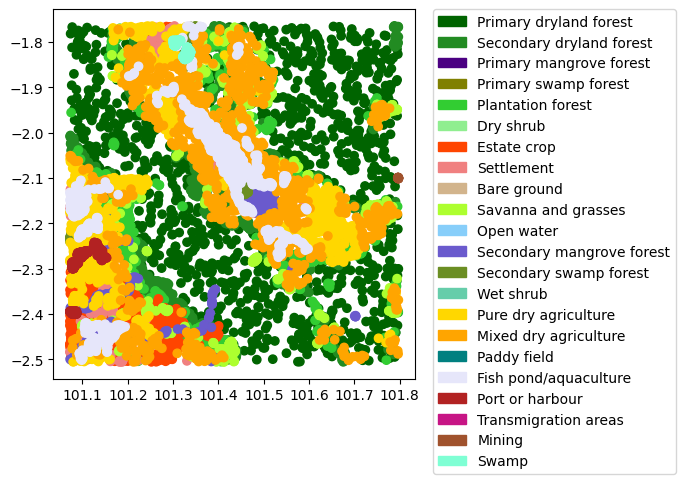

In [4]:
# Load sample
sample = gpd.read_file(sample_dir)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

# Plot sample
sample.plot(column="value", categorical=True, cmap=cmap)
plt.legend(**legend)

# Sample with extract
sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.29967..2.554].


id     lc                    geometry  value  \
0          0   2001  POINT (101.67155 -1.86099)      1   
1          1   2001  POINT (101.43871 -2.23694)      1   
2          2   2001  POINT (101.49341 -1.77152)      1   
3          3   2001  POINT (101.75132 -2.02161)      1   
4          4   2001   POINT (101.1242 -1.96125)      1   
...      ...    ...                         ...    ...   
14024  14024  50011  POINT (101.32983 -1.83297)     22   
14025  14025  50011  POINT (101.33306 -1.82461)     22   
14026  14026  50011   POINT (101.33064 -1.8362)     22   
14027  14027  50011  POINT (101.30207 -1.80063)     22   
14028  14028  50011   POINT (101.32363 -1.8362)     22   

                        label      B1      B2      B3      B4      B5      B6  \
0      Primary dryland forest  0.0091  0.0136  0.0321  0.0205  0.2243  0.0994   
1      Primary dryland forest  0.0101  0.0159  0.0439  0.0292  0.3572  0.1479   
2      Primary dryland forest  0.0205  0.0223  0.0389  0.0273  0.2772  0.1287   
3      Primary dryland forest  0.0058  0.0133  0.0385  0.0247  0.2979  0.1405   
4      Primary dryland forest  0.0174  0.0209  0.0400  0.0252  0.3285  0.1337   
...                       ...     ...     ...     ...     ...     ...     ...   
14024                   Swamp  0.0187  0.0235  0.0419  0.0425  0.1372  0.1336   
14025                   Swamp  0.0205  0.0240  0.0407  0.0496  0.1509  0.1315   
14026                   Swamp  0.0239  0.0278  0.0546  0.0443  0.2668  0.1430   
14027                   Swamp  0.0315  0.0407  0.0621  0.0588  0.2338  0.1386   
14028                   Swamp  0.0213  0.0251  0.0450  0.0389  0.1899  0.1339   

           B7      B9  
0      0.0408  0.0019  
1      0.0560  0.0027  
2      0.0554  0.0033  
3      0.0579  0.0027  
4      0.0543  0.0024  
...       ...     ...  
14024  0.0820  0.0026  
14025  0.0788  0.0027  
14026  0.0719  0.0023  
14027  0.0839  0.0031  
14028  0.0697  0.0021  

[14029 rows x 13 columns]

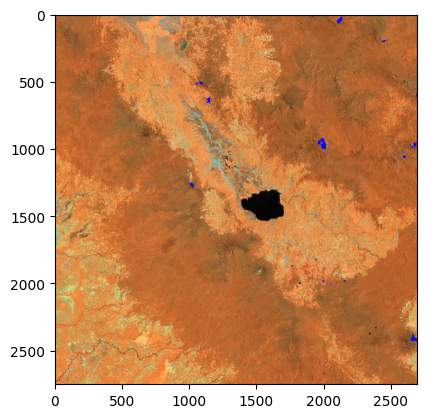

In [5]:
# Load landsat image
landsat = rio.open(landsat_dir)
landsat_image = landsat.read()

# False color composite
arr_image = np.stack(
    [landsat_image[4] * 2.5, landsat_image[5] * 3.3, landsat_image[6] * 4]
).T
composite = np.rot90(np.flip(arr_image, 1), 1) / 1e4

# Plot landsat image
plt.imshow(composite)

# Extract raster value
landsat_extract = np.stack(
    [x for x in landsat.sample(coords)]
) / 1e4
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]] = landsat_extract
sample_extract

id     lc                    geometry  value  \
0          0   2001  POINT (101.67155 -1.86099)      1   
1          1   2001  POINT (101.43871 -2.23694)      1   
2          2   2001  POINT (101.49341 -1.77152)      1   
3          3   2001  POINT (101.75132 -2.02161)      1   
4          4   2001   POINT (101.1242 -1.96125)      1   
...      ...    ...                         ...    ...   
14024  14024  50011  POINT (101.32983 -1.83297)     22   
14025  14025  50011  POINT (101.33306 -1.82461)     22   
14026  14026  50011   POINT (101.33064 -1.8362)     22   
14027  14027  50011  POINT (101.30207 -1.80063)     22   
14028  14028  50011   POINT (101.32363 -1.8362)     22   

                        label      B1      B2      B3      B4      B5      B6  \
0      Primary dryland forest  0.0091  0.0136  0.0321  0.0205  0.2243  0.0994   
1      Primary dryland forest  0.0101  0.0159  0.0439  0.0292  0.3572  0.1479   
2      Primary dryland forest  0.0205  0.0223  0.0389  0.0273  0.2772  0.1287   
3      Primary dryland forest  0.0058  0.0133  0.0385  0.0247  0.2979  0.1405   
4      Primary dryland forest  0.0174  0.0209  0.0400  0.0252  0.3285  0.1337   
...                       ...     ...     ...     ...     ...     ...     ...   
14024                   Swamp  0.0187  0.0235  0.0419  0.0425  0.1372  0.1336   
14025                   Swamp  0.0205  0.0240  0.0407  0.0496  0.1509  0.1315   
14026                   Swamp  0.0239  0.0278  0.0546  0.0443  0.2668  0.1430   
14027                   Swamp  0.0315  0.0407  0.0621  0.0588  0.2338  0.1386   
14028                   Swamp  0.0213  0.0251  0.0450  0.0389  0.1899  0.1339   

           B7      B9      HH      HV  
0      0.0408  0.0019  -7.608 -11.281  
1      0.0560  0.0027  -7.931 -11.993  
2      0.0554  0.0033  -7.901 -11.999  
3      0.0579  0.0027  -7.223 -11.135  
4      0.0543  0.0024  -8.136 -12.624  
...       ...     ...     ...     ...  
14024  0.0820  0.0026 -12.472 -19.294  
14025  0.0788  0.0027 -11.963 -19.554  
14026  0.0719  0.0023  -9.416 -15.761  
14027  0.0839  0.0031 -10.746 -18.832  
14028  0.0697  0.0021  -9.975 -15.855  

[14029 rows x 15 columns]

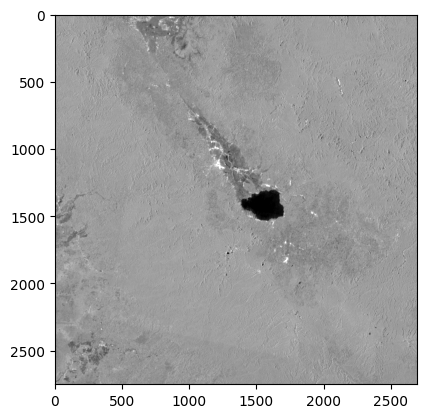

In [6]:
# Load palsar image
palsar = rio.open(palsar_dir)
palsar_image = palsar.read(
    out_shape=(palsar.count, landsat_image.shape[1], landsat_image.shape[2]),
    resampling=Resampling.bilinear,
)

# Plot landsat image
plt.imshow(palsar_image[0] / 1e3, cmap="gray", vmin=-20, vmax=0)

# Extract raster value
palsar_extract = np.stack([x for x in palsar.sample(coords)]) / 1e3
sample_extract[["HH", "HV"]] = palsar_extract
sample_extract

In [7]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 9820
Test size: 4209


In [8]:
# Make random forest model
predictors = ["B1", "B2", "B3", 'B4', 'B5', 'B6', 'B7', "B9", 'HH', 'HV']
model = RandomForestClassifier(100)
model.fit(
    train[predictors],
    train["value"]
)

RandomForestClassifier()

              precision    recall  f1-score   support

           1       0.53      0.76      0.62       298
           2       0.45      0.42      0.44       309
           5       0.57      0.80      0.66       322
           6       0.35      0.19      0.25       293
           7       0.54      0.63      0.58       280
           8       0.60      0.57      0.59       303
           9       0.44      0.36      0.39       321
          11       0.93      0.88      0.90       295
          14       0.62      0.65      0.63       303
          15       0.35      0.25      0.29       291
          16       0.28      0.26      0.27       289
          17       0.70      0.70      0.70       297
          20       0.71      0.75      0.73       308
          21       0.80      0.57      0.67         7
          22       0.84      0.88      0.86       293

    accuracy                           0.58      4209
   macro avg       0.58      0.58      0.57      4209
weighted avg       0.56   

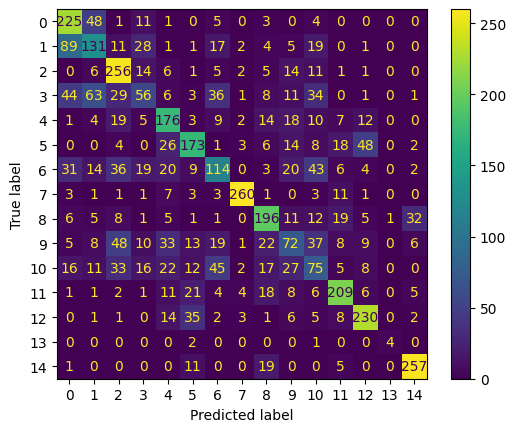

In [9]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['value'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['value'], test_apply)
print(report)

In [11]:
# Load image
combine_image = np.concatenate((landsat_image / 1e4, palsar_image / 1e3), 0)
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9", "HH", "HV"],
)

In [12]:
# Predict table image
prediction = model.predict(table_image[predictors])
prediction

array([1, 1, 6, ..., 1, 1, 1])

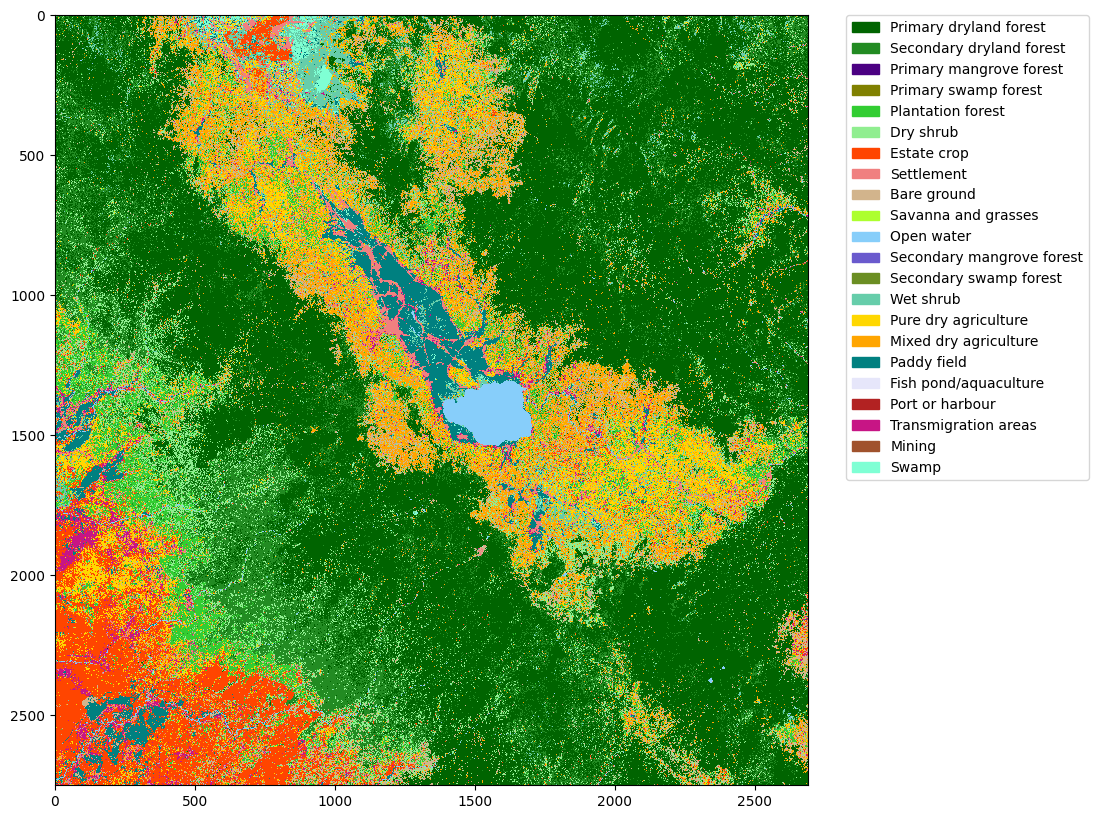

In [14]:
# Prediction to image again
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation='nearest')
plt.legend(**legend)

In [21]:
# Save image to geotiff
output = rio.open(
    "data/LULC.tif",
    "w",
    "COG",
    count=1,
    width=prediction_image.shape[1],
    height=prediction_image.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(prediction_image, 1)
output.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.29967..2.554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.299670000000045..2.5540000000000376].


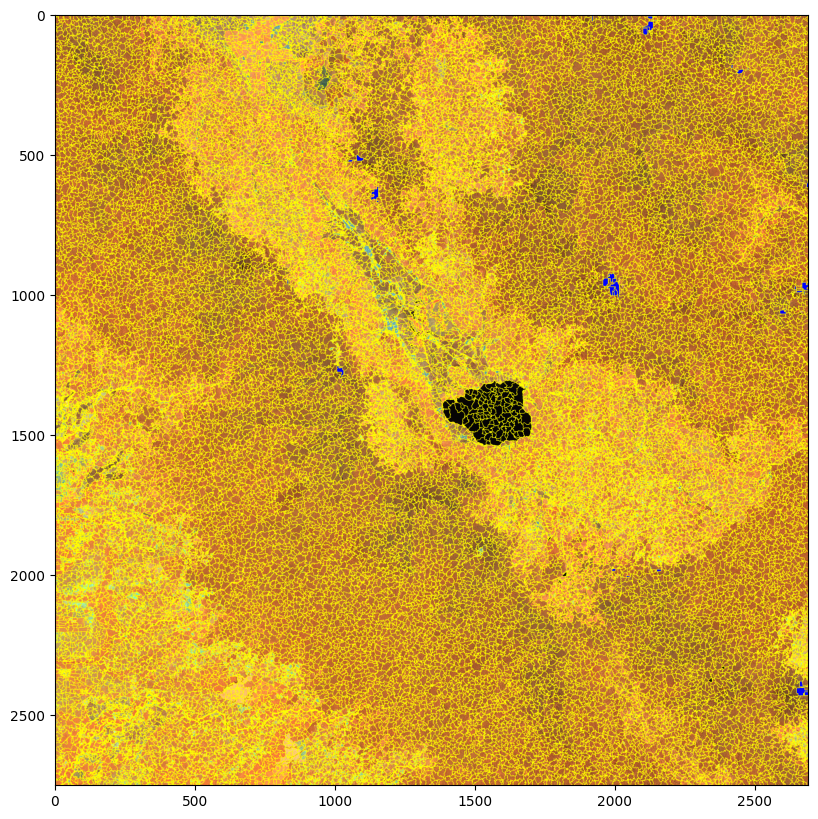

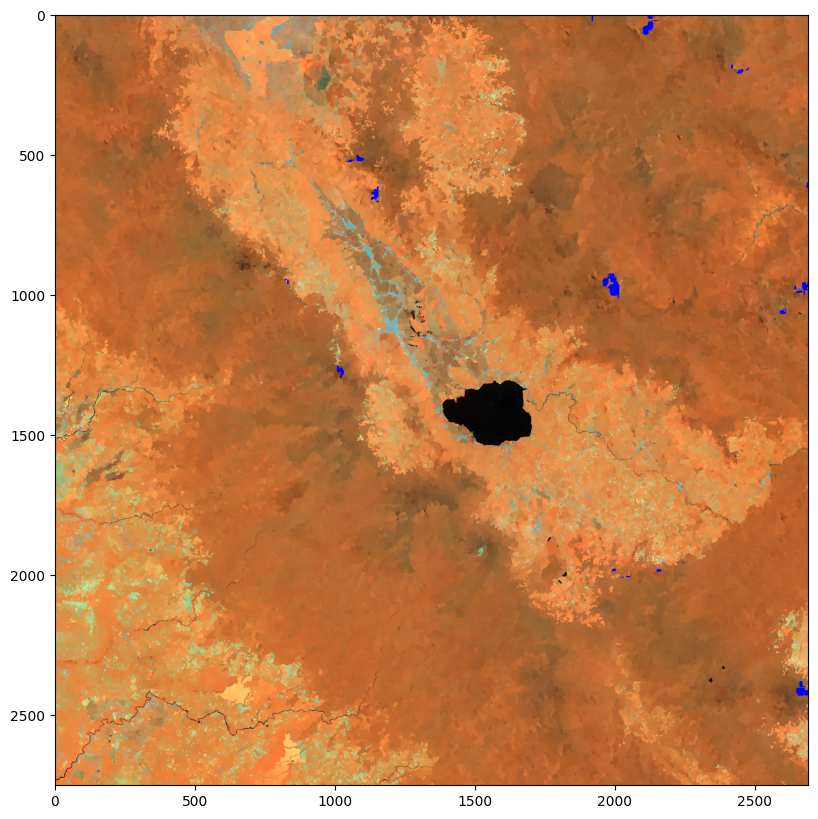

In [16]:
# Image segmentation
seed_image = composite
segment = ski.segmentation.quickshift(seed_image, kernel_size=3, max_dist=6, ratio=0.5)
plt.figure(figsize=(10, 10))
plt.imshow(ski.segmentation.mark_boundaries(composite, segment))

In [17]:
# Get the mode of each segment
segment_unique = np.unique(segment)
lc_segment = segment.copy()
for x in segment_unique:
    lc_segment[segment == x] = scipy.stats.mode(prediction_image[segment == x]).mode
lc_segment

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1],
       [7, 7, 7, ..., 1, 1, 1]])

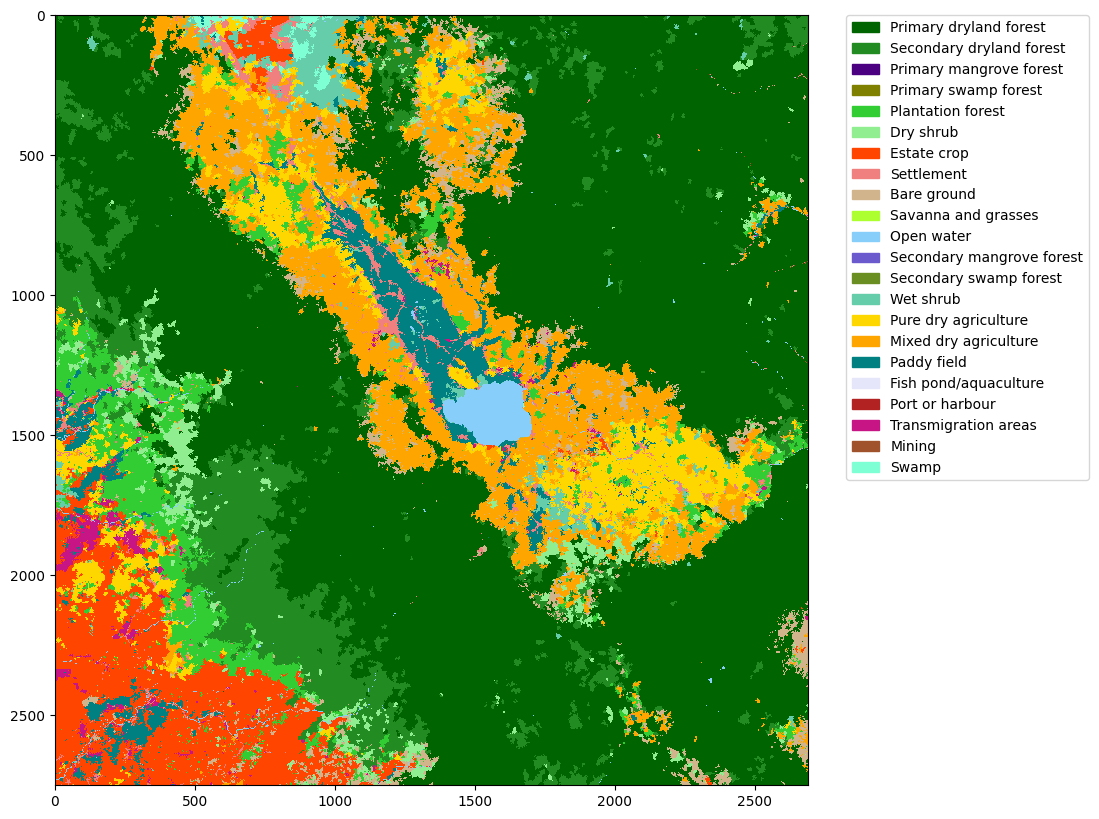

In [20]:
# Show to plot the segmented LC
plt.figure(figsize=(10, 10))
plt.imshow(lc_segment, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

# Save image to geotiff
output = rio.open(
    "data/LULC_Segment.tif",
    "w",
    "COG",
    count=1,
    width=lc_segment.shape[1],
    height=lc_segment.shape[0],
    crs=landsat.crs,
    transform=landsat.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(lc_segment, 1)
output.close()